# Cats, Dogs and Pandas Image Classification

Hello Everyone, I hope you are doing well. 

In this notebook, I will try the process of implementing CNN with Keras in order to classify images.
* First, We'll import packages.
* Then, we'll load the data. Before visualising and preprocessing it.
* We'll try a simple CNN model
* We will evaluate its performance.
* We'll Check any overfitting issues and rectify them.
* Then, We'll Predict the Given Image using the CNN final model
* Save the CNN model

<a id="1"></a> <br>
# 1. Import Packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from keras import regularizers
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sbn
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
import cv2
import os
from sklearn.utils import shuffle
from tqdm import tqdm
from keras import losses
from keras.wrappers.scikit_learn import KerasClassifier
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import PIL.Image
import itertools
from keras_tuner import RandomSearch

<a id="2"></a> <br>
# 2. Load Images

In [2]:
#Function for loading images
def load_images():
    global image
    images=[]
    labels=[]
    cat_path=r"../input/animal-image-datasetdog-cat-and-panda/animals/cats/"
    dog_path=r"../input/animal-image-datasetdog-cat-and-panda/animals/dogs/"
    panda_path=r"../input/animal-image-datasetdog-cat-and-panda/animals/panda/"
    
    
    #Finding total images in each animal folder
    _,_, files = next(os.walk(cat_path))
    cat_count = len(files)
    _,_, files = next(os.walk(dog_path))
    dog_count = len(files)
    _,_, files = next(os.walk(panda_path))
    panda_count = len(files)
    #Setting labels for each category
    labels=np.concatenate((np.zeros(cat_count), np.ones(dog_count), np.ones(panda_count)*2), axis=0)
    datasets=[cat_path, dog_path, panda_path]
    
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            
            #Get the path name for each image
            image_path = os.path.join(folder, file)
            
            #Open the image
            image = cv2.imread(image_path)
            
            #Resize the image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (224, 224))
            
            #Append images and labels
            images.append(image)
    images=np.array(images, dtype='float32')
    return images, labels

In [3]:
images, labels = load_images()
images.shape, labels.shape

100%|██████████| 1000/1000 [00:09<00:00, 102.70it/s]


((3000, 224, 224, 3), (3000,))

<a id="3"></a> <br>
# 3. Exploratory Data Analysis

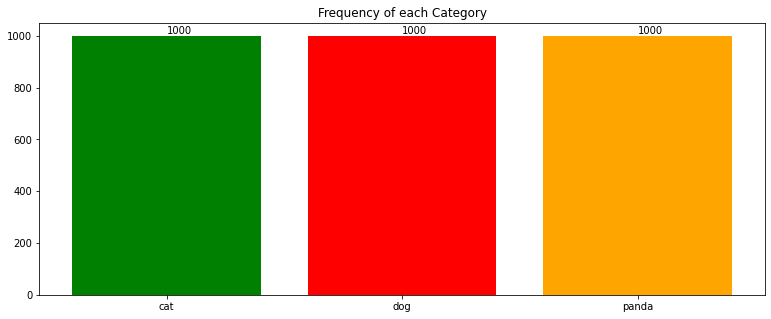

In [4]:
#Frequency of each Category
label_data={'cat':0, 'dog':1, 'panda':2}
plt.figure(figsize=(13,5))
plt.title("Frequency of each Category")
plt.bar(height=pd.Series(labels).value_counts(), x=pd.Series(labels).value_counts().index.astype('int'), tick_label=list(label_data.keys()), color=['green', 'red', 'orange'])
for i, j in zip(pd.Series(labels).value_counts(), pd.Series(labels).value_counts().index.astype('int')):
    plt.annotate(str(i), xy=(j, i), xytext=(j, i), va='bottom')
plt.show()

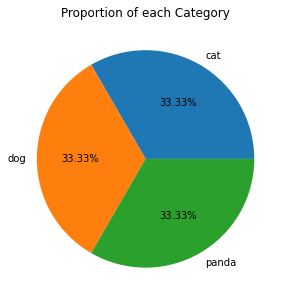

In [5]:
#Proportion of each Category
plt.figure(figsize=(13,5))
plt.title("Proportion of each Category")
plt.pie(x=pd.Series(labels).value_counts(), labels=list(label_data.keys()),  autopct='%.2f%%')
plt.show()

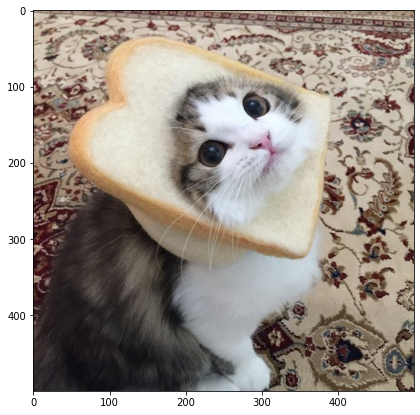

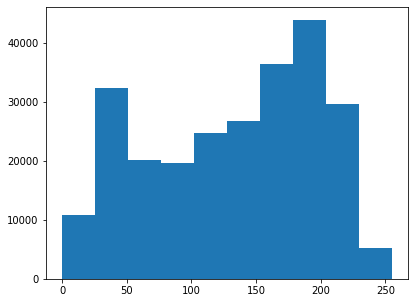

In [6]:
#Distribution colors of Cat Image
image = cv2.imread(r"../input/animal-image-datasetdog-cat-and-panda/images/cat.jpg")
plt.figure(figsize=(13, 7))
plt.imshow(PIL.Image.open(r"../input/animal-image-datasetdog-cat-and-panda/images/cat.jpg"))
plt.show()
plt.figure(figsize=(6.5, 5))
plt.hist(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).flatten())
plt.show()

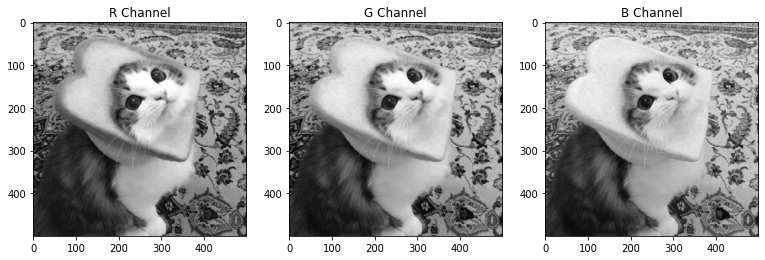

In [7]:
# Isolate RGB channels of the Cat Image
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]
# Visualize the individual color channels of the Dog Image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 7))
ax1.set_title("R Channel")
ax1.imshow(r, cmap="gray")
ax2.set_title("G Channel")
ax2.imshow(g, cmap="gray")
ax3.set_title("B Channel")
ax3.imshow(b, cmap="gray")

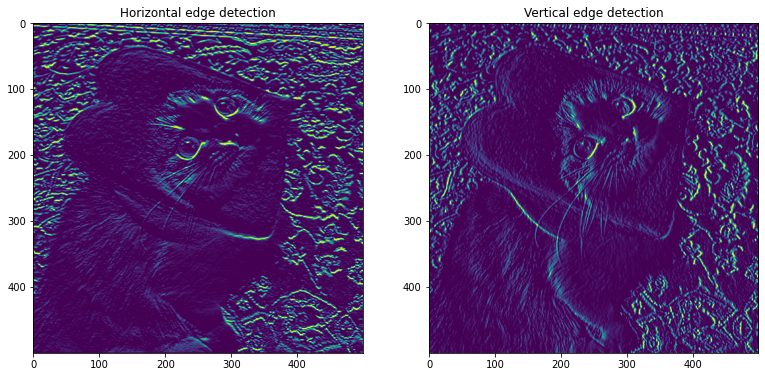

In [8]:
#Horizontal and Vertical edge detection of the image
# Convert to grayscale image
hor_kernal = np.array([[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]])
ver_kernal = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.set_title("Horizontal edge detection")
ax1.imshow(cv2.filter2D(gray_image, -1, hor_kernal))
ax2.set_title("Vertical edge detection")
ax2.imshow(cv2.filter2D(gray_image, -1, ver_kernal))

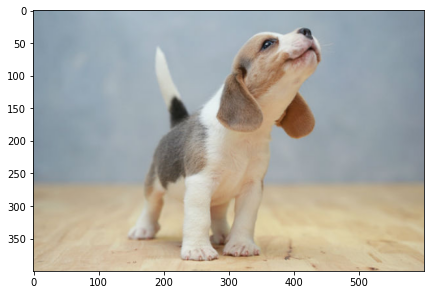

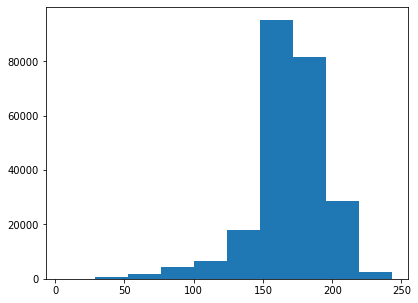

In [9]:
#Distribution colors of Dog Image
image = cv2.imread(r"../input/animal-image-datasetdog-cat-and-panda/images/dog.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7, 7))
plt.imshow(PIL.Image.open(r"../input/animal-image-datasetdog-cat-and-panda/images/dog.jpg"))
plt.show()
plt.figure(figsize=(6.5, 5))
plt.hist(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).flatten())
plt.show()

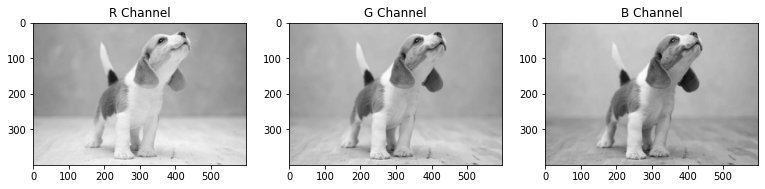

In [10]:
# Isolate RGB channels of the Dog Image
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]
# Visualize the individual color channels of the Dog Image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 7))
ax1.set_title("R Channel")
ax1.imshow(r, cmap="gray")
ax2.set_title("G Channel")
ax2.imshow(g, cmap="gray")
ax3.set_title("B Channel")
ax3.imshow(b, cmap="gray")

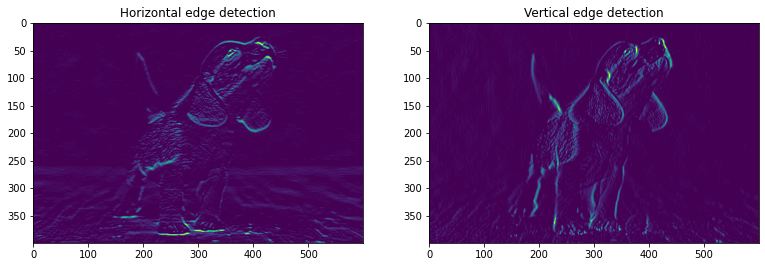

In [11]:
#Horizontal and Vertical edge detection of the image
# Convert to grayscale image
hor_kernal = np.array([[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]])
ver_kernal = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.set_title("Horizontal edge detection")
ax1.imshow(cv2.filter2D(gray_image, -1, hor_kernal))
ax2.set_title("Vertical edge detection")
ax2.imshow(cv2.filter2D(gray_image, -1, ver_kernal))

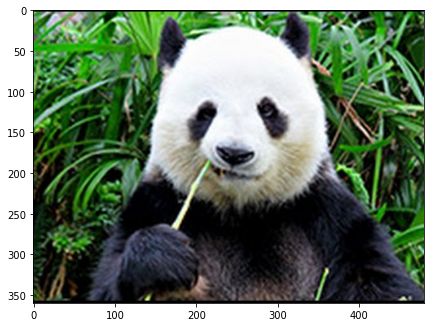

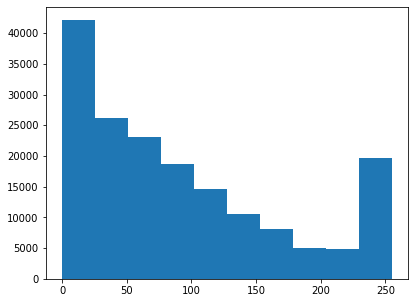

In [12]:
#Distribution colors of Panda Image
image = cv2.imread(r"../input/animal-image-datasetdog-cat-and-panda/images/panda.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7, 7))
plt.imshow(PIL.Image.open(r"../input/animal-image-datasetdog-cat-and-panda/images/panda.jpg"))
plt.show()
plt.figure(figsize=(6.5, 5))
plt.hist(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).flatten())
plt.show()

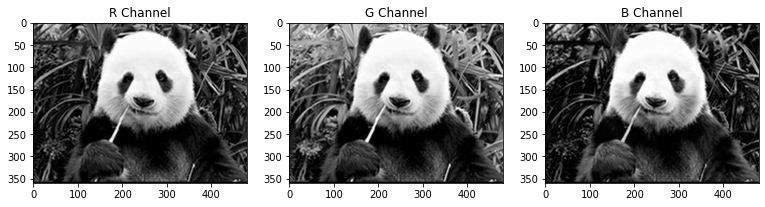

In [13]:
# Isolate RGB channels of the Panda Image
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]
# Visualize the individual color channels of the Dog Image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 7))
ax1.set_title("R Channel")
ax1.imshow(r, cmap="gray")
ax2.set_title("G Channel")
ax2.imshow(g, cmap="gray")
ax3.set_title("B Channel")
ax3.imshow(b, cmap="gray")

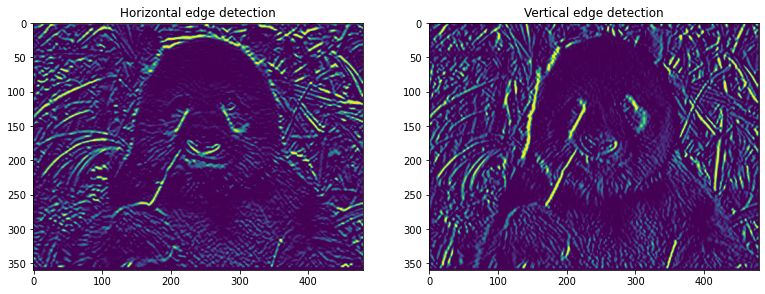

In [14]:
#Horizontal and Vertical edge detection of the image
# Convert to grayscale image
hor_kernal = np.array([[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]])
ver_kernal = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
ax1.set_title("Horizontal edge detection")
ax1.imshow(cv2.filter2D(gray_image, -1, hor_kernal))
ax2.set_title("Vertical edge detection")
ax2.imshow(cv2.filter2D(gray_image, -1, ver_kernal))

<a id="4"></a> <br>
# 4. Data Preprocessing

**The Features should be normalized**

In [15]:
images=images/255
images[0]

array([[[0.84313726, 0.8       , 0.78431374],
        [0.8745098 , 0.8352941 , 0.81960785],
        [0.89411765, 0.85882354, 0.8392157 ],
        ...,
        [0.41960785, 0.41960785, 0.37254903],
        [0.41568628, 0.41568628, 0.36862746],
        [0.41568628, 0.41568628, 0.36862746]],

       [[0.8392157 , 0.79607844, 0.78039217],
        [0.87058824, 0.83137256, 0.8156863 ],
        [0.8862745 , 0.8509804 , 0.83137256],
        ...,
        [0.41960785, 0.41960785, 0.37254903],
        [0.41568628, 0.41568628, 0.37254903],
        [0.41568628, 0.41568628, 0.36862746]],

       [[0.8352941 , 0.7921569 , 0.7764706 ],
        [0.8627451 , 0.8235294 , 0.8039216 ],
        [0.88235295, 0.84705883, 0.827451  ],
        ...,
        [0.42352942, 0.42352942, 0.38431373],
        [0.41960785, 0.41960785, 0.38039216],
        [0.41960785, 0.41960785, 0.38039216]],

       ...,

       [[0.26666668, 0.24313726, 0.34509805],
        [0.27450982, 0.2509804 , 0.3529412 ],
        [0.2784314 , 0

In [16]:
#train test split 75:25 ratio
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=10)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2400, 224, 224, 3), (600, 224, 224, 3), (2400,), (600,))

<a id="5"></a> <br>
# 5. Model Building and Compilation

In [17]:
#Model Building
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.7))
model.add(Dense(units=3, activation='softmax'))

In [18]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0

<a id="5a"></a> <br>
# 6. Model Fitting and Evaluation

In [19]:
history = model.fit(x=x_train, y=to_categorical(y_train), epochs=6, validation_data=(x_test, to_categorical(y_test)), batch_size=20)

Epoch 1/6
120/120 [==============================] - 10s 23ms/step - loss: 0.9969 - accuracy: 0.5113 - val_loss: 0.7964 - val_accuracy: 0.5883
Epoch 2/6
120/120 [==============================] - 2s 15ms/step - loss: 0.7890 - accuracy: 0.6062 - val_loss: 0.7355 - val_accuracy: 0.6133
Epoch 3/6
120/120 [==============================] - 2s 15ms/step - loss: 0.7237 - accuracy: 0.6275 - val_loss: 0.7319 - val_accuracy: 0.6183
Epoch 4/6
120/120 [==============================] - 2s 15ms/step - loss: 0.6614 - accuracy: 0.6596 - val_loss: 0.7636 - val_accuracy: 0.6350
Epoch 5/6
120/120 [==============================] - 2s 15ms/step - loss: 0.6515 - accuracy: 0.6637 - val_loss: 0.7367 - val_accuracy: 0.6450
Epoch 6/6
120/120 [==============================] - 2s 16ms/step - loss: 0.5998 - accuracy: 0.7063 - val_loss: 0.6563 - val_accuracy: 0.6800


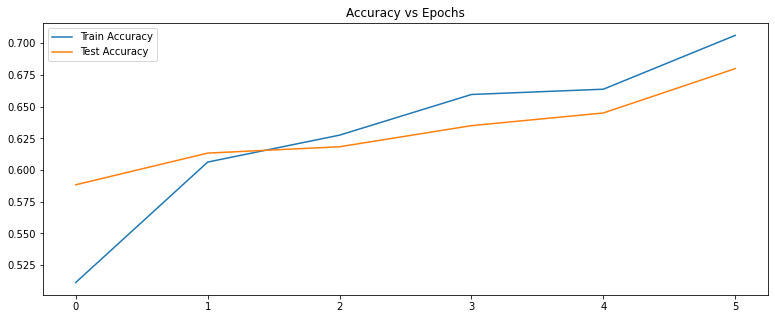

In [20]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

# 7. Hyperparameter Tuning

In [21]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('num_of_neurons', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('rate', min_value=0.1, max_value=0.7, step=0.1)))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [22]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5, executions_per_trial=3)

In [23]:
#Parameters to tune
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_of_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': None}


In [24]:
#Fitting the tuner on train dataset
tuner.search(x=x_train, y=to_categorical(y_train), epochs=6, validation_data=(x_test, to_categorical(y_test)), batch_size=20)

Trial 5 Complete [00h 01m 04s]
val_accuracy: 0.699999988079071

Best val_accuracy So Far: 0.7016666531562805
Total elapsed time: 00h 04m 59s


In [25]:
#The hyperparameters selected by KerasTuner
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_of_neurons: 224
rate: 0.30000000000000004
Score: 0.7016666531562805
Trial summary
Hyperparameters:
num_of_neurons: 288
rate: 0.6
Score: 0.7016666531562805
Trial summary
Hyperparameters:
num_of_neurons: 96
rate: 0.1
Score: 0.7005555431048075
Trial summary
Hyperparameters:
num_of_neurons: 384
rate: 0.7000000000000001
Score: 0.700000007947286
Trial summary
Hyperparameters:
num_of_neurons: 320
rate: 0.2
Score: 0.699999988079071


In [26]:
#best Model
best_model = tuner.get_best_models()[0]

In [27]:
predicted_classes = np.argmax(best_model.predict(x_test), axis=-1)

In [28]:
#Test Accuracy
accuracy_score(y_test, predicted_classes)

0.715

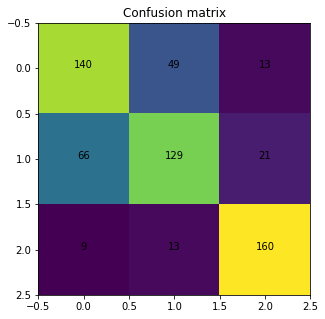

In [29]:
#Confusion Matrix
plt.figure(figsize=(13,5))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

<a id="8"></a> <br>
# 8. Predicting the Given image

**Now I will take an image for prediction.**

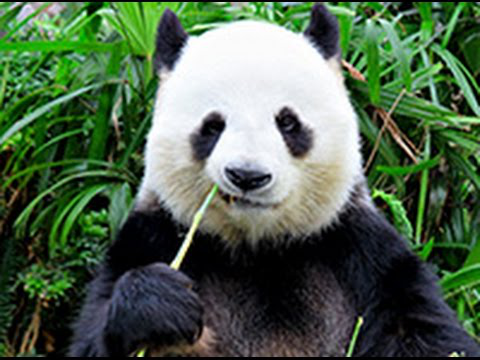

In [30]:
image=PIL.Image.open(r"../input/animal-image-datasetdog-cat-and-panda/images/panda.jpg")
image

In [31]:
#Prediction
image = cv2.imread(r"../input/animal-image-datasetdog-cat-and-panda/images/panda.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=cv2.resize(image, (224, 224))
image = np.array(image, dtype='float32')/255
pred = np.argmax(best_model.predict(image.reshape(1,224,224,3)).flatten())
for key, value in label_data.items():
    if pred == value:
        print(key)

panda


<a id="9"></a> <br>
# 9. Save the Model

In [32]:
#Save the model
best_model.save('/kaggle/working/model.h5')